## Data preparation and sanitization

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

from utils.preprocessing import df_to_xy

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")
#df = pd.read_excel("./UG_HH_NEW_categorical_no200.xls")
df = df.dropna()


x, y = df_to_xy(df, fuse_risk=True, centered=True, min_target=5, max_target=190)

## Linear regression (continuous dataset)

**Accuracy / Loss - For model comparison**

In [2]:
MAX_GAIN = 200


#### Benchmark

In [3]:
from utils.benchmark import process_benchmarks, process_benchmark_cv, process_model


Using TensorFlow backend.


**Keras Model**

In [4]:
from models import KerasModel, loss_tf, gain_tf

In [5]:
import os, sys


In [6]:
# #sci-kit like training
# sm = keras_model("mse") 
# history = sm.fit(xTrain, yTrain, validation_split=0.33, epochs=100, batch_size=64, verbose=0)
# loss_hist = pd.DataFrame(data={'loss': history.history['loss']})
# loss_hist.plot(figsize=(30,10))
# smPredict = sm.predict(xTest, batch_size=128)

# out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(smPredict)})
# stl = sm.evaluate(xTest, yTest, verbose=0)
# print("Results: %2.2f (%.2f) MSE, Scalar test loss: %.2f" % (smPredict.mean(), smPredict.std(), stl))
# #out_data.plot(figsize=(30,10))

**Featureless model (fixed value)**

In [7]:
from models import FeaturelessModel

**Convervative model**

In [8]:
from models import ConservativeModel

**Linear/Logistic regression**

In [9]:
from sklearn.linear_model import LinearRegression, LogisticRegression

**Random**

In [10]:
from models import RandomModel

**Random Forest**

In [11]:
from sklearn.ensemble.forest import RandomForestClassifier, RandomForestRegressor

**Clustering**

In [12]:
from models import ClusterModel, ClusterExtModel

In [13]:
from sklearn.neural_network import MLPClassifier

** Acceptance model **

In [14]:
from models import AcceptanceModel

** Data augmentation **

In [15]:
from utils.data_augmentation import DACombine

**Baseline models**

In [16]:
from sklearn.svm import SVC

benchmark_models = {
    #Featureless:
    #"random": RandomModel(MAX_GAIN),
    #"conservative": ConservativeModel(MAX_GAIN),
    "featureless": FeaturelessModel(MAX_GAIN),
    "svc": SVC(gamma='auto') 
#     "linear_regressor": LinearRegression(copy_X=False),
#     "linear_regressor_mse": keras_linear_regression(loss="mse"),
}

results = dict()
# for key, model in benchmark_models.items():
#     results[key] = process_benchmark_cv(model, x, y.ravel())
#     results[key+"_da"] = process_benchmark_cv(model, x, y.ravel(), augment_data=2)
#results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}
results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None, 2])

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
featureless,26.897619,0.218055,23.998552,963.0,1505.321429,0.066825
featureless_da2,42.659524,0.346746,41.420400,1526.0,2561.869048,0.050000
svc,26.897619,0.218055,23.998552,963.0,1505.321429,0.066825
svc_da2,81.060317,0.710048,22.867262,2902.0,9034.246032,0.653651


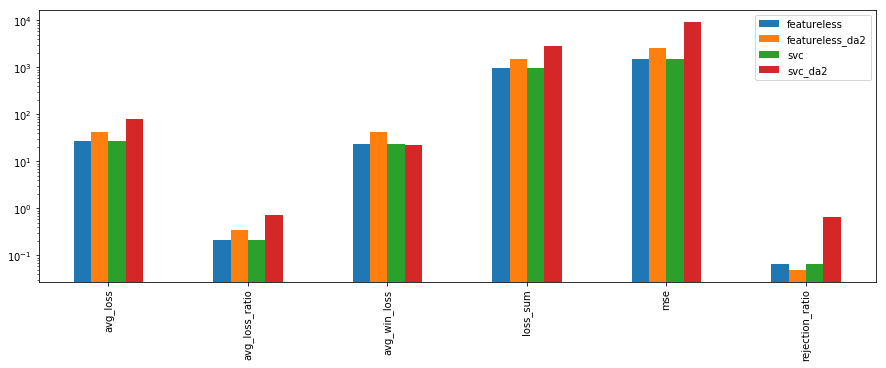

In [17]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Clustering based models**

In [18]:
benchmark_models = {
#     #Cluster-based
    "affinity": ClusterModel(base_model="affinity"),
#     "bayes": ClusterModel(base_model="bayes", n_components=8),
#     "birch": ClusterModel(base_model="birch"),
#     "kmeans": ClusterModel(base_model="kmeans", n_clusters=16),
    "meanshift": ClusterModel(base_model="meanshift", cluster_all=True),
    "affinity_ext": ClusterExtModel(base_model="affinity"),
#     "bayes_ext": ClusterExtModel(base_model="bayes", n_components=8),
#     "birch_ext": ClusterExtModel(base_model="birch"),
#     "kmeans_ext": ClusterModel(base_model="kmeans", n_clusters=16),
    "meanshift_ext": ClusterExtModel(base_model="meanshift", cluster_all=True),
}

results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
affinity,37.779206,0.325621,27.949628,1353.8,2480.991905,0.150000
affinity_ext,30.123016,0.247157,23.564694,1079.0,1967.440476,0.100159
meanshift,32.409524,0.261931,30.656535,1160.2,1766.825397,0.055556
meanshift_ext,26.897619,0.218055,23.998552,963.0,1505.321429,0.066825


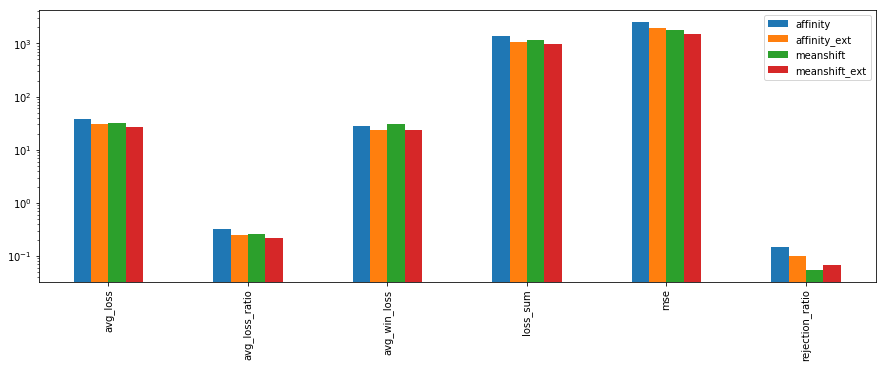

In [19]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Other models**

In [20]:
benchmark_models = {
    'featureless': FeaturelessModel(),
    # Regression
    #"random_forest_regr": RandomForestRegressor(min_samples_leaf=5),
    'logistic_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
    #"nn_regression_hiddenless": KerasModel(no_hidden_layer=True),
    "nn_regression": KerasModel(batch_size=30, epochs=200),
    'acceptance_model': AcceptanceModel(step=10, zero_one=True),
    # Classification
    #"random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
}

results = dict()

results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None, 2])
results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

/home/franck/Desktop/MA-Thesis/code/notebooks/models/metrics.py:12: RuntimeWarning: invalid value encountered in greater
  rejected = min_offer > predicted
/home/franck/Desktop/MA-Thesis/code/notebooks/models/metrics.py:16: RuntimeWarning: invalid value encountered in less
  bad_predictions = (predicted < 0) | (predicted > MAX_GAIN)
/home/franck/Desktop/MA-Thesis/code/notebooks/models/metrics.py:16: RuntimeWarning: invalid value encountered in greater
  bad_predictions = (predicted < 0) | (predicted > MAX_GAIN)
/home/franck/Desktop/MA-Thesis/code/notebooks/models/metrics.py:40: RuntimeWarning: invalid value encountered in less_equal
  accepted = (min_offer <= predicted)
/home/franck/Desktop/MA-Thesis/code/notebooks/models/metrics.py:49: RuntimeWarning: invalid value encountered in less_equal
  accepted = (min_offer <= predicted)
/home/franck/Desktop/MA-Thesis/code/notebooks/models/metrics.py:59: RuntimeWarning: invalid value encountered in less
  res[predicted < min_offer] = 0
/home/fr

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
acceptance_model,30.019841,0.265468,21.724914,1075.000000,1723.654762,0.128254
acceptance_model_da2,32.997619,0.296717,19.743202,1181.000000,2256.242063,0.178254
featureless,26.897619,0.218055,23.998552,963.000000,1505.321429,0.066825
featureless_da2,38.381746,0.311909,36.656535,1372.000000,2267.146825,0.055556
logistic_regression,26.080159,0.229628,15.759543,933.000000,1828.337302,0.133968
logistic_regression_da2,76.747619,0.659338,23.408692,2746.000000,8495.349206,0.581270
nn_regression,NaN,NaN,0.000000,NaN,NaN,1.000000
nn_regression_da2,42.120123,0.360166,16.176716,1502.103204,3096.895276,0.511746


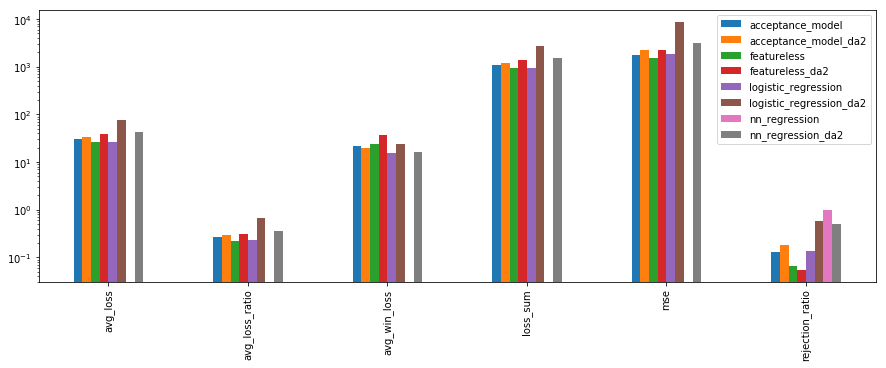

In [21]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**TOP MODELS**

In [22]:
from sklearn.svm import SVR
benchmark_models = {
    'featureless': FeaturelessModel(),
    'logistic_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
    'svc': SVC(gamma='auto'),
    'acceptance_model': AcceptanceModel(step=10, zero_one=True),
    'acceptance_model_svr': AcceptanceModel(SVR(gamma='auto', kernel='poly', degree=1), step=10, zero_one=True),
    
    # Classification
    #"random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
}

results = dict()

results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=None, shuffle=True)
results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
acceptance_model,32.386508,0.274978,27.415630,1159.0,1705.638889,0.084921
acceptance_model_svr,31.654762,0.266094,28.426471,1133.0,1556.099206,0.067778
featureless,26.872222,0.218179,23.828632,963.0,1505.099206,0.067302
logistic_regression,25.769048,0.226499,16.077431,923.0,1784.940476,0.128730
svc,26.872222,0.218179,23.828632,963.0,1505.099206,0.067302


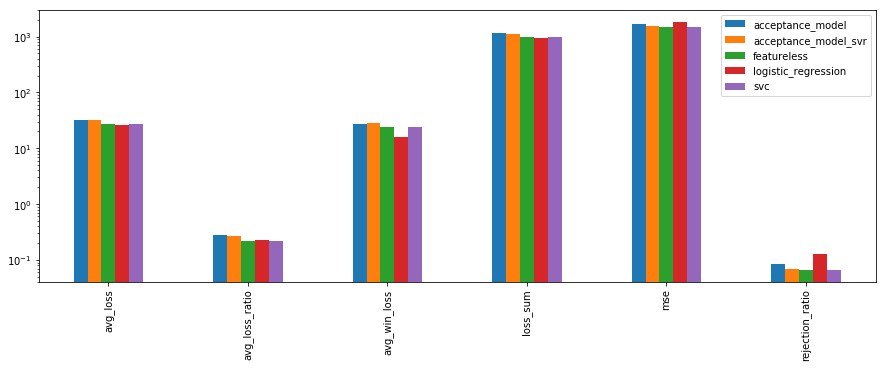

In [23]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))